## Config

In [1]:
import re
import time
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import brentq
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import ttest_ind, ttest_rel, wilcoxon

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Variance trading

Reference and inspired by 
### Derman, Emanuel; Miller, Michael B.. The Volatility Smile: An Introduction for Students and Practitioners (Wiley Finance) (p. 79). Wiley. Kindle Edition. 

Problem with previous approach
- option pricing does not solely depend on volatiliy factor. Even though we can precisely predict volatility  (in this case depending on the past IV), the option price will be reflected by the movement of the stock movement.
- Additionaly, Vega and Kappa are themselves affected by the level of moneyness. thus introducing another factor into profitability.



incremental profit earned from delta-hedging an option using the implied volatility hedge ratio over the next instant of time dt:

$$
\text{Profit} = \frac{1}{2} \Gamma S^2 (\sigma_R^2 - \Sigma^2) \, dt
$$


If we can eliminate the first part, we would get the variance swap on the second part.
This can be done by create a portfolio of vanilla options where Γ was equal to 1/S2


$$
V = \frac{\partial C}{\partial \sigma} = \frac{S \sqrt{\tau}}{\sqrt{2\pi}} e^{-\frac{1}{2} d_1^2}
$$

$$
\kappa = \frac{\partial C}{\partial \sigma^2} = \frac{S \sqrt{\tau}}{2\sigma \sqrt{2\pi}} e^{-\frac{1}{2} d_1^2}
$$
assuming validation of BSM model and formula
construc a portfolio where weighted proportionally to 1/K^2 woulr result in stable kappa with such desired character

we assume that we purchase puts for those strikes between 0 and some break point S*, and calls for strikes greater than S*. At expiration ,the  payoff is 

$$
\pi(S_T, S^*, 0) = \int_0^{S^*} \frac{1}{K^2} P(S_T, K, 0) \, dK + \int_{S^*}^{\infty} \frac{1}{K^2} C(S_T, K, 0) \, dK
$$

$$
= \int_{S^*}^{S_T} \frac{1}{K^2} (S_T - K) \, dK
$$

$$
= \left( \frac{S_T - S^*}{S^*} \right) - \ln \left( \frac{S_T}{S^*} \right)
$$

Equivaently, long 1/S* of forward and short a log contract

Next, scale this portgolio by 2/T, the payoff will be

$$
\pi(S_T, S_0, T, T) = \frac{2}{T} \left[ \left( \frac{S_T - S_0}{S_0} \right) - \ln \left( \frac{S_T}{S_0} \right) \right]
$$

Now finding the value before expiration
$$
\pi(S, S^*, t, T) = \frac{2}{T} \left[ \left( \frac{S - S^*}{S^*} \right) - \ln \left( \frac{S}{S^*} \right) \right] + \frac{T - t}{T} \sigma^2
$$

S= S0 = S* at inception, the value of portfolio is 

$$
\pi(S_0, S_0, 0, T) = \sigma^2
$$

Assuming r = 0

In a BSM world, the initial fair value of our properly scaled replicating portfolio is equal to σ2, the variance of the underlying stock. By continuously hedging a log contract, properly scaled, we can produce a portfolio whose value is the variance of the stock, independent of the stock price.

Derman, Emanuel; Miller, Michael B.. The Volatility Smile: An Introduction for Students and Practitioners (Wiley Finance) (p. 71). Wiley. Kindle Edition. 

There are 2 ways to trade variance of stock, by this replication portfolio
1. if log contract is available, long 1/S* of forward and short a log contract
2. manual replicate portfolio with weighted proportional to 1/K^2

## Variance by replicating portfolio

### limitation
- Assuming r = 0
- In practice, with finite number of option available, the following approximation would always bias and highly likely to overestimate the actual value of variance

### methodology
1. given available market price of each option, with Put for K below S0 and Call for K above S0
Out-of-the-money puts with low strike prices tend to be more liquid than in-the-money puts with high strike prices.
to be practical we assume that we purchase puts for those strikes between 0 and some break point S*, and calls for strikes greater than S*.

2. cal π(Ki) 
$$
\pi(K_i, S_0, T, T) = \frac{2}{T} \left[ \left( \frac{K_i - S_0}{S_0} \right) - \ln \left( \frac{K_i}{S_0} \right) \right]
$$

3. cal absolute of slopes, λi,

$$
\frac{\pi(K_i) - \pi(K_{i-1})}{K_i - K_{i-1}}
$$

4. then use the absolute value of the slopes, λi, to calculate the weights for the options.

$$
V(t) = \dots + (\lambda_1^P - \lambda_0^P) P(K_ P^1) + \lambda_0^P P(K_0) + \lambda_0^C C(K_0)
$$

$$
+ (\lambda_1^C - \lambda_0^C) C(K_C^1) + \dots
$$


5. Wi * Option price Put for K below S0 and Call for K above S0
6. summation of [5] = variance of the underlying stock 
7. squared root [6] we get volatility of the underlying stock >> another 'implied' variance

Trade idea would be if the value of the above portfolio which is the impled variance is less than what we expect (to be the fair level of variance or vol), then long the portfolio, vice versa

#### download raw data

In [3]:
options_data=pd.read_csv("../data/spy_2020_2022.csv")
options_data.rename(columns=lambda x: str(x).replace("[", "").replace("]", "").strip(), inplace=True)
options_data['EXPIRE_DATE'] = options_data['EXPIRE_DATE'].str.strip()
options_data['QUOTE_DATE'] = options_data['QUOTE_DATE'].str.strip()
options_data = options_data.rename(columns={"UNDERLYING_LAST": "S", "STRIKE": "K", "QUOTE_DATE": "t", "EXPIRE_DATE": "T"})

# Convert relevant columns to numeric (handling errors gracefully)
numeric_cols = ['P_ASK', 'P_BID', 'C_ASK', 'C_BID']
options_data[numeric_cols] = options_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Now, safely compute mid prices
options_data['P_MID'] = (options_data['P_ASK'] + options_data['P_BID']) / 2
options_data['C_MID'] = (options_data['C_ASK'] + options_data['C_BID']) / 2

/var/folders/hx/dgqrg7351bd65gnmsv4npl8c0000gn/T/ipykernel_34772/574204307.py:1: DtypeWarning: Columns (8,9,10,11,12,13,15,17,18,20,21,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  options_data=pd.read_csv("../data/spy_2020_2022.csv")


In [4]:
pd.set_option('display.max_columns', None)  # Show all columns
options_data.head(85)
# pd.reset_option('display.max_columns')

,QUOTE_UNIXTIME,QUOTE_READTIME,t,QUOTE_TIME_HOURS,S,T,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,K,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,P_MID,C_MID
0,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,0.000000,0.000000,0.005170,,1.000000,182.650000,1 x 1,181.09,182.31,270.0,0.00,0.01,0 x 2239,0.010000,-0.000240,0.000000,0.000040,-0.005090,0.000000,3.412490,3.000000,181.9,0.402,0.005,181.700
1,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,0.000000,0.000000,0.005270,,,0.000000,1 x 1,176.09,177.31,275.0,0.00,0.01,0 x 2679,0.010000,-0.000630,0.000030,0.000190,-0.004800,0.000000,3.297370,0.000000,176.9,0.391,0.005,176.700
2,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,0.000000,0.000000,0.005690,,25.000000,157.750000,1 x 1,171.09,172.31,280.0,0.00,0.01,0 x 2679,0.010000,0.000000,0.000000,-0.000230,-0.005340,0.000000,3.183300,11.000000,171.9,0.380,0.005,171.700
3,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,0.000000,0.000000,0.005300,,25.000000,153.450000,1 x 1,166.14,167.30,285.0,0.00,0.01,0 x 2679,0.010000,-0.000160,0.000040,0.000380,-0.005320,0.000000,3.072170,50.000000,166.9,0.369,0.005,166.720
4,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,0.000000,0.000000,0.005340,,25.000000,147.760000,1 x 1,161.09,162.31,290.0,0.00,0.01,0 x 2679,0.010000,-0.000680,0.000000,0.000450,-0.005150,0.000000,2.962300,0.000000,161.9,0.358,0.005,161.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,0.000000,0.000000,0.008860,,5519.000000,1.690000,10 x 10,1.68,1.79,450.0,0.00,0.01,0 x 1134,0.010000,-0.016640,0.046990,0.008340,-0.004540,-0.000550,0.042900,48093.000000,1.9,0.004,0.005,1.735
81,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,0.000000,-0.000570,0.009300,,22637.000000,0.750000,485 x 2,0.71,0.78,451.0,0.01,0.02,4179 x 1299,0.010000,-0.063540,0.225780,0.025730,-0.015120,-0.000610,0.027790,66590.000000,0.9,0.002,0.015,0.745
82,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,0.294410,1.164470,0.069720,-0.054990,0.002740,0.014980,134982.000000,0.060000,116 x 2,0.05,0.06,452.0,0.26,0.31,2 x 1,0.300000,-0.628310,0.773990,0.076640,-0.124980,-0.005120,0.024180,206924.000000,0.1,0.000,0.285,0.055
83,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,0.051140,0.148270,0.020940,-0.015620,-0.000020,0.034660,209154.000000,0.010000,257 x 4088,0.01,0.02,453.0,1.17,1.35,1 x 1,1.310000,-0.836640,0.205400,0.049720,-0.100340,-0.005880,0.058230,77917.000000,1.1,0.003,1.260,0.015


In [5]:
options_data_surface = options_data.loc[
    options_data['T'] == '2022-12-30',
    ['t', 'T', 'DTE', 'S', 'K', 'C_IV', 'P_IV', 'C_DELTA', 'P_DELTA']
]
options_data_surface



,t,T,DTE,S,K,C_IV,P_IV,C_DELTA,P_DELTA
227568,2022-08-01,2022-12-30,151.04,410.72,150.0,0.704330,0.621120,0.989330,-0.003220
227569,2022-08-01,2022-12-30,151.04,410.72,160.0,0.654910,0.598120,0.989560,-0.003880
227570,2022-08-01,2022-12-30,151.04,410.72,170.0,0.594640,0.577080,0.990020,-0.005200
227571,2022-08-01,2022-12-30,151.04,410.72,180.0,0.556060,0.555630,0.989910,-0.005730
227572,2022-08-01,2022-12-30,151.04,410.72,190.0,-0.000290,0.534480,1.000000,-0.007800
...,...,...,...,...,...,...,...,...,...
2454814,2022-03-31,2022-12-30,274.04,451.77,585.0,0.154750,0.176750,0.03313,-0.919
2454815,2022-03-31,2022-12-30,274.04,451.77,590.0,0.164060,0.183340,0.03693,-0.91714
2454816,2022-03-31,2022-12-30,274.04,451.77,595.0,0.163220,0.189130,0.03108,-0.9149
2454817,2022-03-31,2022-12-30,274.04,451.77,600.0,0.155000,,0.02154,-1.0


In [6]:
options_data_surface[pd.to_numeric(options_data_surface['C_IV'],  errors='coerce')>1]

,t,T,DTE,S,K,C_IV,P_IV,C_DELTA,P_DELTA
896411,2022-12-01,2022-12-30,29.0,407.40,150.0,3.062400,1.014590,0.86009,0.0
896412,2022-12-01,2022-12-30,29.0,407.40,160.0,2.775300,0.951080,0.86407,-0.00002
896413,2022-12-01,2022-12-30,29.0,407.40,170.0,2.499480,0.891400,0.86918,0.0
896414,2022-12-01,2022-12-30,29.0,407.40,180.0,2.273860,0.835160,0.87299,-0.00028
896415,2022-12-01,2022-12-30,29.0,407.40,190.0,2.072160,0.781410,0.87836,-0.00031
...,...,...,...,...,...,...,...,...,...
2333914,2022-02-24,2022-12-30,309.0,428.06,150.0,1.036850,0.545240,0.85788,-0.00943
2343759,2022-02-28,2022-12-30,305.0,436.52,150.0,1.055680,0.599240,0.85542,-0.01346
2353397,2022-03-02,2022-12-30,303.0,437.79,150.0,1.063980,0.568540,0.85554,-0.01004
2362946,2022-03-04,2022-12-30,301.0,432.25,150.0,1.049830,0.571450,0.8568,-0.01087


#### Explore data

In [7]:
def plot_two_smiles(df, col_left='C_IV', col_right='P_IV', n_lines=5, bins=50, title='Vol Smiles'):
    d = df.copy()
    d['moneyness'] = np.log(d['K'] / d['S'])
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=['DTE','moneyness', col_left, col_right])
    d[col_left]  = pd.to_numeric(d[col_left],  errors='coerce')
    d[col_right] = pd.to_numeric(d[col_right], errors='coerce')
    d = d.dropna(subset=[col_left, col_right])

    # choose representative DTEs (quantiles)
    qs = np.linspace(0.1, 0.9, n_lines)
    dtes = np.quantile(d['DTE'].values, qs)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    def _plot_side(ax, iv_col, title_col):
        for t in dtes:
            # take nearest points around that DTE
            sl = d.iloc[(d['DTE'] - t).abs().argsort()[:1000]].copy()
            # bin by moneyness to smooth
            sl['bin'] = pd.cut(sl['moneyness'], bins=bins)
            g = sl.groupby('bin', observed=True)[['moneyness', iv_col]].median().dropna()
            ax.plot(g['moneyness'], g[iv_col], marker='o', ms=2, lw=1, label=f"DTE≈{t:.0f}")
        ax.set_title(title_col)
        ax.set_xlabel("log-moneyness ln(K/S)")
        ax.set_ylabel("IV")
        ax.grid(True)
        ax.legend(ncol=2, fontsize=8)

    _plot_side(axes[0], col_left,  col_left)
    _plot_side(axes[1], col_right, col_right)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Usage
# plot_two_smiles(options_data_surface, col_left='C_IV', col_right='P_IV', n_lines=5, bins=50)


In [8]:
def _make_surface_data(df, iv_col):
    """Return grid and smoothed Z for a given IV column."""
    d = df.copy()
    d['moneyness'] = np.log(d['K'] / d['S'])
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=['DTE','moneyness', iv_col])
    d[iv_col] = pd.to_numeric(d[iv_col], errors='coerce')
    d = d.dropna(subset=[iv_col])

    m_vals = d['moneyness'].values
    t_vals = d['DTE'].values
    z_vals = d[iv_col].values

    m_grid = np.linspace(m_vals.min(), m_vals.max(), 60)
    t_grid = np.linspace(t_vals.min(), t_vals.max(), 60)
    T, M = np.meshgrid(t_grid, m_grid)

    Z = griddata((t_vals, m_vals), z_vals, (T, M), method='linear')
    Z_fallback = griddata((t_vals, m_vals), z_vals, (T, M), method='nearest')
    Z = np.where(np.isnan(Z), Z_fallback, Z)
    Z = gaussian_filter(Z, sigma=1.0)

    return T, M, Z

def plot_two_surfaces(df, col1='C_IV', col2='P_IV'):
    # build two surfaces
    T1, M1, Z1 = _make_surface_data(df, col1)
    T2, M2, Z2 = _make_surface_data(df, col2)

    fig = plt.figure(figsize=(18, 7))

    # --- First surface (C_IV) ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    s1 = ax1.plot_surface(T1, M1, Z1, cmap='viridis', alpha=0.9, edgecolor='none')
    ax1.set_title(col1)
    ax1.set_xlabel("DTE")
    ax1.set_ylabel("log-moneyness ln(K/S)")
    ax1.set_zlabel(col1)
    fig.colorbar(s1, ax=ax1, shrink=0.6, aspect=10, label=col1)

    # --- Second surface (P_IV) ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    s2 = ax2.plot_surface(T2, M2, Z2, cmap='plasma', alpha=0.9, edgecolor='none')
    ax2.set_title(col2)
    ax2.set_xlabel("DTE")
    ax2.set_ylabel("log-moneyness ln(K/S)")
    ax2.set_zlabel(col2)
    fig.colorbar(s2, ax=ax2, shrink=0.6, aspect=10, label=col2)

    plt.tight_layout()
    plt.show()


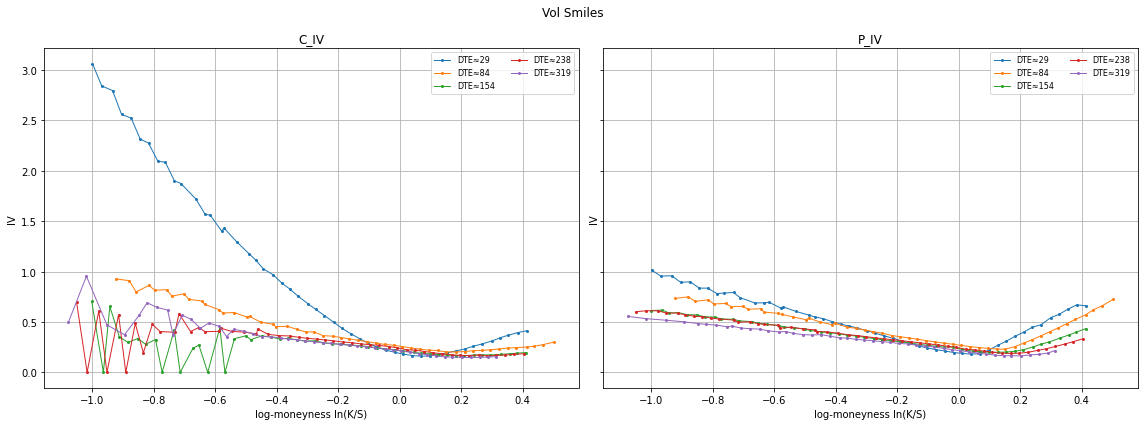

In [9]:
plot_two_smiles(options_data_surface, col_left='C_IV', col_right='P_IV', n_lines=5, bins=50)

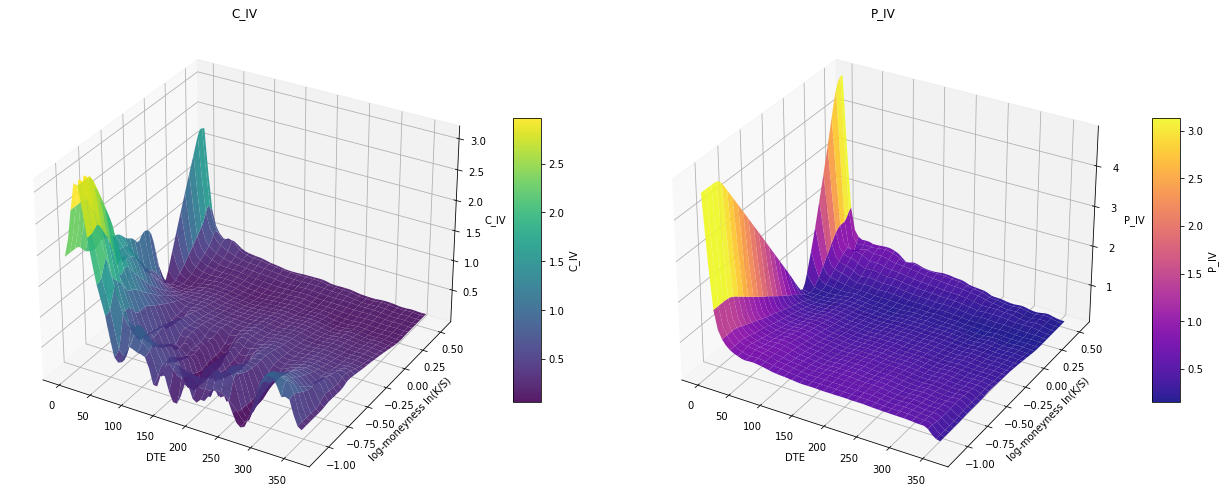

In [10]:
plot_two_surfaces(options_data_surface, col1='C_IV', col2='P_IV')


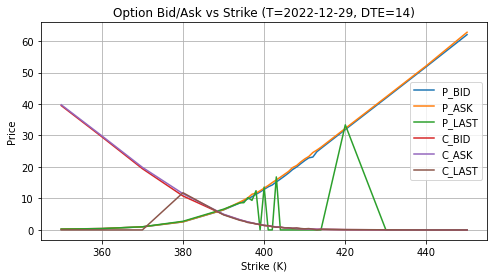

In [11]:
df_filtered = options_data[(options_data['T'] == '2022-12-29') & (options_data['DTE'] == 14)]

plt.figure(figsize=(8,4))
plt.plot(df_filtered['K'], df_filtered['P_BID'], label='P_BID')
plt.plot(df_filtered['K'], df_filtered['P_ASK'], label='P_ASK')
plt.plot(df_filtered['K'], df_filtered['P_LAST'], label='P_LAST')
plt.plot(df_filtered['K'], df_filtered['C_BID'], label='C_BID')
plt.plot(df_filtered['K'], df_filtered['C_ASK'], label='C_ASK')
plt.plot(df_filtered['K'], df_filtered['C_LAST'], label='C_LAST')

plt.xlabel('Strike (K)')
plt.ylabel('Price')
plt.title('Option Bid/Ask vs Strike (T=2022-12-29, DTE=14)')
plt.legend()
plt.grid(True)
plt.show()


For some series, there was no trading activity. Thus last price is shown as zero. and we are using mid price from now on

#### Calculation of volatility, variance by replicating portfolio method

In [12]:
def IV_rep_port(options_data, quote_date, expiry_date, price_used = 'mid'):
    """
    Compute the implied volatility replication portfolio based on given quote and expiry dates.
    
    Parameters:
    options_data (DataFrame): The dataset containing options market data.
    quote_date (str): The trade date in format 'YYYY-MM-DD'.
    expiry_date (str): The expiry date in format 'YYYY-MM-DD'.
    
    Returns:
    tuple: (vol, variance, length of combined_data, combined_data DataFrame)
    vol (float): The implied volatility by replicating portfolio.
    variance (float): The variance by replicating portfolio.
    length (int): The length of the combined_data DataFrame meaning the number of different options in the replication portfolio for a specific expiry and quote date.
    combined_data (DataFrame): The combined_data DataFrame containing all the option information in the replication portfolio for a specific expiry and quote date.
    """
    # Filter the data for the specified quote and expiry dates
    filtered_data = options_data[
        (options_data['t'].str.strip() == quote_date) &
        (options_data['T'].str.strip() == expiry_date)
    ]
    
    # Sort values by strike price (K)
    filtered_data = filtered_data.sort_values(by="K", ascending=True).copy()
    
    # Ensure DTE is not zero to avoid division errors
    filtered_data = filtered_data[filtered_data['DTE'] > 0].copy()
    
    # Compute π using the given formula
    _1_forward = (filtered_data['K'] - filtered_data['S']) / filtered_data['S']
    _2_log_contract = np.log(filtered_data['K'] / filtered_data['S'])
    filtered_data['pi'] = (2 * 365 / filtered_data['DTE']) * (_1_forward - _2_log_contract)
    
    # Process put options (K < S)
    filtered_data_put = filtered_data[filtered_data['K'] < filtered_data['S']].copy()
    filtered_data_put = filtered_data_put[["t", "T", "S", "K", "pi", "P_LAST", "P_BID", "P_ASK"]]
    filtered_data_put['side'] = 'P'
    filtered_data_put['lambda'] = ((filtered_data_put['pi'].diff()) / (filtered_data_put['K'].diff())).abs()
    filtered_data_put["w"] = filtered_data_put["lambda"] - filtered_data_put["lambda"].shift(-1)
    filtered_data_put.at[filtered_data_put.index[-1], "w"] = filtered_data_put.at[filtered_data_put.index[-1], "lambda"]
    
    # Process call options (K >= S)
    filtered_data_call = filtered_data[filtered_data['K'] >= filtered_data['S']].copy()
    filtered_data_call = filtered_data_call[["t", "T", "S", "K", "pi", "C_LAST", "C_BID", "C_ASK"]]
    filtered_data_call['side'] = 'C'
    filtered_data_call['lambda'] = (-filtered_data_call['pi'].diff(-1) / filtered_data_call['K'].diff(-1)).abs()
    filtered_data_call["w"] = filtered_data_call["lambda"] - filtered_data_call["lambda"].shift(1)
    filtered_data_call.at[filtered_data_call.index[0], "w"] = filtered_data_call.at[filtered_data_call.index[0], "lambda"]
    
    # Combine put and call data
    combined_data = pd.concat([filtered_data_put, filtered_data_call], ignore_index=True)
    
    # Find the center index where K is closest to S
    center_idx = (combined_data['K'] - combined_data['S']).abs().idxmin()
    
    # Assign center indicator
    combined_data['center'] = 0
    combined_data.loc[center_idx, 'center'] = 1
    
    # Remove rows where w is NaN
    combined_data = combined_data.dropna(subset=['w'])
    
    # Ensure numeric types for price columns
    combined_data['P_LAST'] = pd.to_numeric(combined_data['P_LAST'], errors='coerce')
    combined_data['C_LAST'] = pd.to_numeric(combined_data['C_LAST'], errors='coerce')
    combined_data['P_ASK'] = pd.to_numeric(combined_data['P_ASK'], errors='coerce')
    combined_data['C_ASK'] = pd.to_numeric(combined_data['C_ASK'], errors='coerce')
    combined_data['P_BID'] = pd.to_numeric(combined_data['P_BID'], errors='coerce')
    combined_data['C_BID'] = pd.to_numeric(combined_data['C_BID'], errors='coerce')
    combined_data['P_MID'] = (combined_data['P_BID'] + combined_data['P_ASK'])/2
    combined_data['C_MID'] = (combined_data['C_BID'] + combined_data['C_ASK'])/2

    # Compute weighted options value
    # combined_data['w_O'] = combined_data['w'] * combined_data.apply(
    #     lambda row: row['P_LAST'] if row['side'] == 'P' else row['C_LAST'], axis=1
    # )
    
    # Define price selection mapping

    price_map = {
    'last': lambda row: row['P_LAST'] if row['side'] == 'P' else row['C_LAST'],
    'bid': lambda row: row['P_BID'] if row['side'] == 'P' else row['C_BID'],
    'ask': lambda row: row['P_ASK'] if row['side'] == 'P' else row['C_ASK'],
    'mid': lambda row: row['P_MID'] if row['side'] == 'P' else row['C_MID'],
    # last adjust >> using last price if available, otherwise mid price
    'last_adj': lambda row: (
        row['P_LAST'] if (row['side'] == 'P' and row['P_LAST'] != 0 )
        else row['P_MID'] if row['side'] == 'P' 
        else row['C_LAST'] if row['C_LAST'] != 0 
        else row['C_MID']
    )
    }

    # Ensure price_used is valid
    if price_used not in price_map:
        raise ValueError(f"Invalid price_used value: {price_used}. Choose from 'last', 'bid', 'ask', 'mid'.")

    # Compute weighted options value based on price_used
    combined_data['w_O'] = combined_data['w'] * combined_data.apply(price_map[price_used], axis=1)

    # Compute variance and volatility
    variance = combined_data['w_O'].sum()
    vol = np.sqrt(variance)
    
    return vol, variance, len(combined_data), combined_data


In [13]:
unique_pairs = options_data[['t', 'T', 'DTE']].drop_duplicates()
unique_pairs = unique_pairs[unique_pairs['t'] != unique_pairs['T']] # delete intraday quote

In [14]:
unique_pairs['t'].drop_duplicates().sort_values()

2455495    2020-01-02
2459287    2020-01-03
2462964    2020-01-06
2466542    2020-01-07
2470229    2020-01-08
              ...    
957333     2022-12-26
960929     2022-12-27
964402     2022-12-28
967922     2022-12-29
971643     2022-12-30
Name: t, Length: 758, dtype: object

In [15]:
unique_pairs['T'].drop_duplicates().sort_values()

2455495    2020-01-03
2455613    2020-01-06
2455673    2020-01-08
2455730    2020-01-10
2455813    2020-01-13
              ...    
228782     2024-06-21
228867     2024-12-20
360394     2025-01-17
898811     2025-03-21
971281     2025-12-19
Name: T, Length: 514, dtype: object

In [16]:
unique_pairs_used = unique_pairs[unique_pairs['T'] == '2022-12-30']

In [17]:
unique_pairs_used

,t,T,DTE
227568,2022-08-01,2022-12-30,151.04
232100,2022-08-02,2022-12-30,150.04
236678,2022-08-03,2022-12-30,149.04
241245,2022-08-04,2022-12-30,148.04
245911,2022-08-05,2022-12-30,147.04
...,...,...,...
2435539,2022-03-25,2022-12-30,280.04
2440403,2022-03-28,2022-12-30,277.04
2445125,2022-03-29,2022-12-30,276.04
2449920,2022-03-30,2022-12-30,275.04


- after choosing 1 unique expiry date
- below, calculate the volatiity and variance from replicating portfolio of different strike price (call and put) for each pair of quote date and chosen expiry date
- for 1 expiry date, runtime 12m

In [18]:
results = []

# Loop through each unique (t, T) pair
for index, row in unique_pairs_used.iterrows():
    quote_date = row['t']
    expiry_date = row['T']
    dte = row['DTE']  # Days to expiry
    
    # Run IV_rep_port function
    try:
        # vol_last, variance_last, data_length, combined_data_last = IV_rep_port(options_data, quote_date, expiry_date, price_used = 'last')
        # vol_ask, variance_ask,_, combined_data_ask = IV_rep_port(options_data, quote_date, expiry_date, price_used = 'ask')
        # vol_last_adj, variance_last_adj, K_length_last_adj , rep_port_last_adj = IV_rep_port(options_data, quote_date, expiry_date, price_used = 'last_adj')
        vol_mid, variance_mid, K_length_mid , rep_port_mid = IV_rep_port(options_data, quote_date, expiry_date, price_used = 'mid')
        # Append results
        results.append({
            't': quote_date,
            'T': expiry_date,
            'DTE': dte,
            # 'vol_last_adj': vol_last_adj,
            # 'variance_last_adj': variance_last_adj,
            # 'data_length': K_length_last_adj,
            # 'rep_port_last_adj': rep_port_last_adj,

            'vol_mid': vol_mid,
            'variance_mid': variance_mid,
            'data_length_mid': K_length_mid,
            'rep_port_mid': rep_port_mid
            # 'vol_ask': vol_ask,
            # 'variance_ask': variance_ask,
            # 'rep_port_ask': combined_data_ask
        })
        
    except Exception as e:
        print(f"Error processing {quote_date} - {expiry_date}: {e}")

# Convert results to a DataFrame
results_df = pd.DataFrame(results).reset_index(drop=True)



In [22]:
results_df = results_df.sort_values(by='DTE', ascending=False).reset_index(drop=True)
results_df['price'] = results_df['vol_mid']

In [23]:
# results_df = results_df.reset_index(drop=True)
# results_df = results_df.sort_values(by='DTE', ascending=False)
# results_df['price'] = results_df['vol_mid']
# results_df

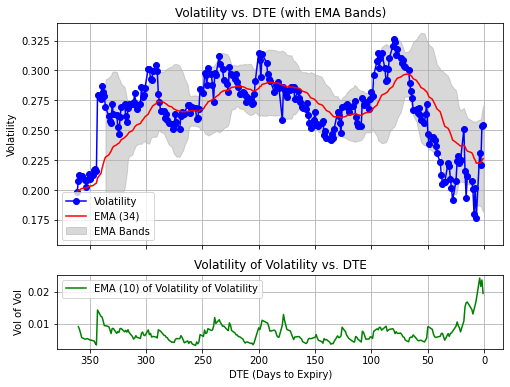

In [24]:
# Compute Volatility EMA
ema_span = 34  # EMA period
results_df['EMA'] = results_df['price'].ewm(span=ema_span, adjust=False).mean()

# Compute rolling standard deviation
rolling_window = 20  # Rolling window for standard deviation
results_df['std'] = results_df['price'].rolling(window=rolling_window).std()

# Compute Upper and Lower Bands (similar to Bollinger Bands)
k = 2  # Multiplier for standard deviation
results_df['upper_band'] = results_df['EMA'] + k * results_df['std']
results_df['lower_band'] = results_df['EMA'] - k * results_df['std']

# Compute volatility of volatility (vol of vol)
results_df['vol_diff'] = results_df['price'].diff().abs()

# Compute EMA for vol of vol
vol_vol_span = 10  # EMA period for vol of vol
results_df['vol_EMA'] = results_df['vol_diff'].ewm(span=vol_vol_span, adjust=False).mean()

# Create subplots with different heights
fig, axes = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Top plot: Volatility vs. DTE with EMA Bands
axes[0].plot(results_df['DTE'], results_df['price'], marker='o', linestyle='-', color='b', label='Volatility')
axes[0].plot(results_df['DTE'], results_df['EMA'], linestyle='-', color='red', label=f'EMA ({ema_span})')
axes[0].fill_between(results_df['DTE'], results_df['upper_band'], results_df['lower_band'], color='gray', alpha=0.3, label='EMA Bands')
axes[0].set_ylabel('Volatility')
axes[0].set_title('Volatility vs. DTE (with EMA Bands)')
axes[0].legend()
axes[0].grid(True)

# Bottom plot: Volatility of Volatility vs. DTE (with lower height)
axes[1].plot(results_df['DTE'], results_df['vol_EMA'], linestyle='-', color='green', label=f'EMA ({vol_vol_span}) of Volatility of Volatility')
axes[1].set_ylabel('Vol of Vol')
axes[1].set_xlabel('DTE (Days to Expiry)')
axes[1].set_title('Volatility of Volatility vs. DTE')
axes[1].legend()
axes[1].grid(True)

# Invert x-axis for both plots
plt.gca().invert_xaxis()



### Signal

One expectation is that volatility tends to be **mean-reverting**.
Let’s explore **mean-reversion-based trading signals**, experimenting with **Bollinger Band–style setups**.


In [25]:
# Define EMA period
ema_span = 10  # Adjust period as needed

results_df['ema_signal'] = results_df['price'].ewm(span=ema_span, adjust=False).mean()

results_df['signal'] = results_df.apply(lambda row: 1 if row['price'] < row['ema_signal'] else -1, axis=1)

In [26]:
results_df

,t,T,DTE,vol_mid,variance_mid,data_length_mid,rep_port_mid,price,EMA,std,upper_band,lower_band,vol_diff,vol_EMA,ema_signal,signal
0,2022-01-03,2022-12-30,361.0,0.198744,0.039499,122,t T S K ...,0.198744,0.198744,NaN,NaN,NaN,NaN,NaN,0.198744,-1
1,2022-01-04,2022-12-30,360.0,0.207858,0.043205,128,t T S K ...,0.207858,0.199265,NaN,NaN,NaN,0.009115,0.009115,0.200401,-1
2,2022-01-05,2022-12-30,359.0,0.212403,0.045115,128,t T S K ...,0.212403,0.200015,NaN,NaN,NaN,0.004545,0.008284,0.202583,-1
3,2022-01-06,2022-12-30,358.0,0.211451,0.044711,128,t T S K ...,0.211451,0.200669,NaN,NaN,NaN,0.000952,0.006951,0.204195,-1
4,2022-01-07,2022-12-30,357.0,0.211602,0.044775,128,t T S K ...,0.211602,0.201294,NaN,NaN,NaN,0.000151,0.005715,0.205542,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2022-12-23,2022-12-30,7.0,0.176670,0.031212,259,t T S K ...,0.176670,0.222389,0.017466,0.257320,0.187457,0.025204,0.017541,0.200328,1
251,2022-12-26,2022-12-30,4.0,0.231087,0.053401,259,t T S K ...,0.231087,0.222886,0.018067,0.259020,0.186751,0.054417,0.024246,0.205920,-1
252,2022-12-27,2022-12-30,3.0,0.221063,0.048869,259,t T S K ...,0.221063,0.222782,0.018017,0.258816,0.186747,0.010024,0.021660,0.208674,-1
253,2022-12-28,2022-12-30,2.0,0.253587,0.064306,259,t T S K ...,0.253587,0.224542,0.020303,0.265148,0.183935,0.032524,0.023635,0.216840,-1


Let try a mean reversion signal 

Composite Bollinger Band signal — triggers when volatility touches the upper or lower band, provided its own short-term volatility (vol-of-vol) remains within a normal range.

In [28]:
def compute_trading_signals(results_df, ema_span=34, std_span=20, volatility_span=10,
                            bb_switch=2, volatility_benchmark=0.015):
    """
    Bollinger/EMA switch logic with vol-of-vol gate:
    - Enter only if vol_EMA >= volatility_benchmark.
    - Reset to flat when crossing EMA.
    - signal2 is the persistent state each day (−1, 0, +1).
    """
    # Indicators
    results_df['EMA']  = results_df['price'].ewm(span=ema_span, adjust=False).mean()
    results_df['std']  = results_df['price'].rolling(window=std_span).std()
    results_df['upper_band'] = results_df['EMA'] + bb_switch * results_df['std']
    results_df['lower_band'] = results_df['EMA'] - bb_switch * results_df['std']
    results_df['vol_diff'] = results_df['price'].diff().abs()
    results_df['vol_EMA']  = results_df['vol_diff'].ewm(span=volatility_span, adjust=False).mean()

    # Outputs
    results_df['signal2'] = 0
    results_df['switch']  = 0

    switch = 0  # -1 short, 0 flat, +1 long

    for i in range(1, len(results_df)):
        vol_today  = results_df.loc[i, 'price']
        EMA        = results_df.loc[i, 'EMA']
        upper_band = results_df.loc[i, 'upper_band']
        lower_band = results_df.loc[i, 'lower_band']
        vol_vol    = results_df.loc[i, 'vol_EMA']

        # ----- reset when crossing EMA (center), mirroring z crosses 0
        if (switch == 1 and vol_today >= EMA) or (switch == -1 and vol_today <= EMA):
            switch = 0

        # ----- enter only from flat AND only if vol-of-vol is sufficient
        if switch == 0 and vol_vol <= volatility_benchmark:
            if vol_today <= lower_band:
                switch = 1       # long from lower band
            elif vol_today >= upper_band:
                switch = -1      # short from upper band

        # store states
        results_df.loc[i, 'switch']  = switch
        results_df.loc[i, 'signal2'] = switch  # persistent state, like sig[i] = switch

    return results_df


In [29]:
results_df = compute_trading_signals(results_df, ema_span=10, std_span=10, volatility_span= 5, bb_switch=1.5, volatility_benchmark=0.01)

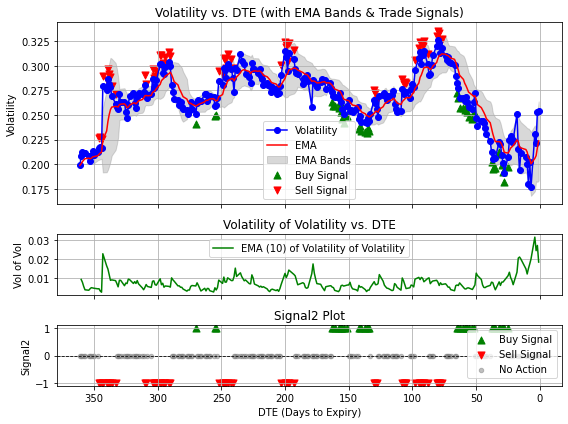

In [30]:
# Create subplots with different heights
fig, axes = plt.subplots(3, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# --- Top plot: Volatility vs. DTE with EMA Bands ---
axes[0].plot(results_df['DTE'], results_df['price'], marker='o', linestyle='-', color='b', label='Volatility')
axes[0].plot(results_df['DTE'], results_df['EMA'], linestyle='-', color='red', label=f'EMA')
axes[0].fill_between(results_df['DTE'], results_df['upper_band'], results_df['lower_band'], color='gray', alpha=0.3, label='EMA Bands')

# --- Add markers for buy/sell signals ---
buy_signal2 = results_df[results_df['signal2'] == 1]
sell_signal2 = results_df[results_df['signal2'] == -1]

# Define spacing offset for markers
marker_offset = 0.01  # Increased spacing for better visibility

# Green markers BELOW the price for buy signals
axes[0].scatter(buy_signal2['DTE'], buy_signal2['price'] - marker_offset,  # Adjusted spacing
                color='green', marker='^', label='Buy Signal', s=50)

# Red markers ABOVE the price for sell signals
axes[0].scatter(sell_signal2['DTE'], sell_signal2['price'] + marker_offset,  # Adjusted spacing
                color='red', marker='v', label='Sell Signal', s=50)

axes[0].set_ylabel('Volatility')
axes[0].set_title('Volatility vs. DTE (with EMA Bands & Trade Signals)')
axes[0].legend()
axes[0].grid(True)

# --- Second plot: Volatility of Volatility vs. DTE ---
axes[1].plot(results_df['DTE'], results_df['vol_EMA'], linestyle='-', color='green', label=f'EMA ({vol_vol_span}) of Volatility of Volatility')
axes[1].set_ylabel('Vol of Vol')
axes[1].set_title('Volatility of Volatility vs. DTE')
axes[1].legend()
axes[1].grid(True)

# --- Third plot: Signal2 Plot (Buy/Sell Markers) ---
neutral_signal2 = results_df[results_df['signal2'] == 0]

axes[2].scatter(buy_signal2['DTE'], buy_signal2['signal2'], color='green', marker='^', label='Buy Signal', s=50)
axes[2].scatter(sell_signal2['DTE'], sell_signal2['signal2'], color='red', marker='v', label='Sell Signal', s=50)
axes[2].scatter(neutral_signal2['DTE'], neutral_signal2['signal2'], color='gray', marker='o', label='No Action', s=20, alpha=0.5)
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.8)  # Baseline at 0
axes[2].set_ylabel('Signal2')
axes[2].set_xlabel('DTE (Days to Expiry)')
axes[2].set_title('Signal2 Plot')
axes[2].legend()
axes[2].grid(True)

# --- Invert x-axis for all plots ---
plt.gca().invert_xaxis()

# Show the final plot
plt.tight_layout()
plt.show()


### Backtest

In [31]:
# Shift variance and replicating portfolio entry to get next day's value
results_df['t_entry']  = results_df['t'].shift(-1)
results_df['variance_entry'] = results_df['variance_mid'].shift(-1) 
results_df['rep_port_entry'] = results_df['rep_port_mid'].shift(-1) 
results_df['no_O_entry'] = results_df['rep_port_entry'].apply(lambda df: len(df) if isinstance(df, pd.DataFrame) else 0)

In [32]:
def update_rep_port_exit(row, options_data, days_to_shift=1):
    """
    Update the replicating portfolio by shifting t forward while ensuring valid option data is available.

    Parameters:
    - row: A single row from results_df containing rep_port_entry.
    - options_data: The full dataset of options prices.
    - days_to_shift: Number of days to shift forward.

    Returns:
    - Updated replicating portfolio dataframe with new option prices and recalculated w_O.
    """
    rep_port_exit = row['rep_port_entry'].copy()  # Copy the portfolio entry
    
    # Convert 't' to datetime for accurate shifting
    rep_port_exit['t'] = pd.to_datetime(rep_port_exit['t'])
    
    # Find the next available trading date
    next_t = rep_port_exit['t'].iloc[0] + pd.Timedelta(days=days_to_shift)
    
    while next_t.strftime('%Y-%m-%d') not in options_data['t'].unique():
        next_t += pd.Timedelta(days=1)  # Keep shifting forward until a valid date is found
    
    # Update 't' in rep_port_exit
    rep_port_exit['t'] = next_t.strftime('%Y-%m-%d')

    # Merge with options_data to update P_LAST and C_LAST prices
    rep_port_exit = rep_port_exit.merge(
        options_data[['t', 'T', 'K', 'P_MID', 'C_MID']],
        on=['t', 'T', 'K'], how='left', suffixes=('', '_new')
    )

    rep_port_exit['P_MID_new'] = pd.to_numeric(rep_port_exit['P_MID_new'], errors='coerce')
    rep_port_exit['C_MID_new'] = pd.to_numeric(rep_port_exit['C_MID_new'], errors='coerce')

    # **Recalculate w_O using updated option prices**
    rep_port_exit['w_O'] = rep_port_exit['w'] * rep_port_exit.apply(
        lambda row: row['P_MID_new'] if row['side'] == 'P' else row['C_MID_new'], axis=1
    )

    return rep_port_exit


#### Update Exit Value

Update the portfolio’s exit value by re-pricing the same option set at a later date, keeping original weights fixed. This differs from a new replication on that future date, since weights are based only on information known at the initial time.


In [33]:
# 6min per 1 expiry date
# Apply the function to each row in results_df with a customizable shift
days_to_shift = 1  # Default is 1, change this as needed

# Step 2: Apply the function only for valid indices
max_valid_index = len(results_df) - days_to_shift 

results_df.reset_index(drop=True, inplace=True)

# Ensure 'rep_port_exit', 't_exit', and 'w_O_exit' columns exist before looping
results_df['rep_port_exit'] = None

# Loop through only valid indices to avoid redundant calculations
for idx in range(max_valid_index):  
    row = results_df.loc[idx]  # Get the current row
    rep_port_exit = update_rep_port_exit(row, options_data, days_to_shift)
    
    # Store results directly, ensuring we don't call update_rep_port_exit() multiple times
    results_df.at[idx, 'rep_port_exit'] = rep_port_exit

In [34]:
results_df['t_exit'] = None
results_df['variance_exit'] = None

results_df['t_exit'] = results_df['rep_port_exit'].apply(
    lambda df: df['t'].iloc[0] if isinstance(df, pd.DataFrame) and not df.empty else None
)

results_df['variance_exit'] = results_df['rep_port_exit'].apply(
    lambda df: df['w_O'].sum() if isinstance(df, pd.DataFrame) and not df.empty else None
)

# Compute 'no_O_exit' efficiently
results_df['no_O_exit'] = results_df['rep_port_exit'].apply(
    lambda df: len(df) if isinstance(df, pd.DataFrame) else 0
)

In [35]:
def plot_price_profit_vs_dte(
    df,
    price_col,                    # e.g. 'price'
    profit_col,                   # e.g. 'profit_entry@t1_exit@t2'
    dte_col='DTE',
    ema_span=34,
    sharpe_span=20,               # new input
    signal_col='signal2',         
    upper_band_col='upper_band',  
    lower_band_col='lower_band',  
    title_prefix='Volatility vs. DTE'
):
    tmp = df[[dte_col, price_col]].copy()
    tmp['price_EMA'] = tmp[price_col].ewm(span=ema_span, adjust=False).mean()
    tmp['above_EMA'] = tmp[price_col] > tmp['price_EMA']

    # cumulative profit (geom)
    cum = (1.0 + df[profit_col]).cumprod()

    # rolling Sharpe ratio
    df['sharpe'] = (
        df[profit_col].rolling(window=sharpe_span).mean() /
        df[profit_col].rolling(window=sharpe_span).std()
    ) * np.sqrt(252)

    fig, axes = plt.subplots(4, 1, figsize=(8, 8),
                             gridspec_kw={'height_ratios': [2, 1, 1, 1]},
                             sharex=True)

    # --- Top plot: price & EMA ---
    axes[0].plot(df[dte_col], df[price_col], marker='o', linestyle='-', label='Price')
    axes[0].plot(df[dte_col], tmp['price_EMA'], linestyle='-', label=f'EMA ({ema_span})')
    for i in range(len(tmp) - 1):
        color = 'green' if tmp['above_EMA'].iloc[i] else 'red'
        axes[0].axvspan(df[dte_col].iloc[i], df[dte_col].iloc[i+1], color=color, alpha=0.2)
    if upper_band_col in df.columns and lower_band_col in df.columns:
        axes[0].fill_between(df[dte_col], df[upper_band_col], df[lower_band_col], alpha=0.3, label='EMA Bands')
    if signal_col in df.columns:
        buys  = df[df[signal_col] == 1]
        sells = df[df[signal_col] == -1]
        off = 0.01
        if not buys.empty:
            axes[0].scatter(buys[dte_col], buys[price_col] - off, color='green', marker='^', s=50, label='Buy')
        if not sells.empty:
            axes[0].scatter(sells[dte_col], sells[price_col] + off, color='red', marker='v', s=50, label='Sell')
    axes[0].set_ylabel('Price')
    axes[0].set_title(f'{title_prefix} (Shaded by Price > EMA)')
    axes[0].legend()
    axes[0].grid(True)

    # --- 2nd plot: daily profit ---
    colors = np.where(df[profit_col] >= 0, 'green', 'red')
    axes[1].bar(df[dte_col], df[profit_col], color=colors)
    axes[1].set_ylabel('Daily Profit')
    axes[1].set_title('Daily Profit vs. DTE')
    axes[1].grid(True)

    # --- 3rd plot: cumulative profit ---
    axes[2].plot(df[dte_col], cum, linestyle='-', marker='o', label='Cumulative Profit')
    axes[2].set_ylabel('Cumulative')
    axes[2].set_title('Cumulative Profit vs. DTE')
    axes[2].legend()
    axes[2].grid(True)

    # --- 4th plot: moving Sharpe ratio ---
    axes[3].plot(df[dte_col], df['sharpe'], color='purple', label=f'Sharpe ({sharpe_span})')
    axes[3].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axes[3].set_ylabel('Sharpe')
    axes[3].set_xlabel('DTE')
    axes[3].set_title('Moving Sharpe Ratio')
    axes[3].legend()
    axes[3].grid(True)

    axes[3].invert_xaxis()
    plt.tight_layout()
    return fig, axes


In [36]:
trading_fee = 0.005

There is one extra assumption using 'profit_entry@t0_exit@t1'. Since our signal detemine by mid price of t0 and also we are executing trading, ie entry on the mid price of that day which is quite unrealistic. However, let try, and we may compensate this via trading fee.

In [37]:
results_df['pct_change'] = results_df['variance_exit'] / results_df['variance_entry'] * (1 - trading_fee) - 1
results_df['profit_entry@t1_exit@t2'] = results_df['pct_change'] * results_df['signal2'] 
results_df['profit_entry@t0_exit@t1'] = results_df['pct_change'].shift(1) * results_df['signal2'] 
results_df

,t,T,DTE,vol_mid,variance_mid,data_length_mid,rep_port_mid,price,EMA,std,upper_band,lower_band,vol_diff,vol_EMA,ema_signal,signal,signal2,switch,t_entry,variance_entry,rep_port_entry,no_O_entry,rep_port_exit,t_exit,variance_exit,no_O_exit,pct_change,profit_entry@t1_exit@t2,profit_entry@t0_exit@t1
0,2022-01-03,2022-12-30,361.0,0.198744,0.039499,122,t T S K ...,0.198744,0.198744,NaN,NaN,NaN,NaN,NaN,0.198744,-1,0,0,2022-01-04,0.043205,t T S K ...,128,t T S K ...,2022-01-05,0.045545,128,0.048894,0.0,NaN
1,2022-01-04,2022-12-30,360.0,0.207858,0.043205,128,t T S K ...,0.207858,0.200401,NaN,NaN,NaN,0.009115,0.009115,0.200401,-1,0,0,2022-01-05,0.045115,t T S K ...,128,t T S K ...,2022-01-06,0.044600,128,-0.016355,-0.0,0.0
2,2022-01-05,2022-12-30,359.0,0.212403,0.045115,128,t T S K ...,0.212403,0.202583,NaN,NaN,NaN,0.004545,0.007591,0.202583,-1,0,0,2022-01-06,0.044711,t T S K ...,128,t T S K ...,2022-01-07,0.044681,128,-0.005669,-0.0,-0.0
3,2022-01-06,2022-12-30,358.0,0.211451,0.044711,128,t T S K ...,0.211451,0.204195,NaN,NaN,NaN,0.000952,0.005378,0.204195,-1,0,0,2022-01-07,0.044775,t T S K ...,128,t T S K ...,2022-01-10,0.043181,128,-0.040430,-0.0,-0.0
4,2022-01-07,2022-12-30,357.0,0.211602,0.044775,128,t T S K ...,0.211602,0.205542,NaN,NaN,NaN,0.000151,0.003636,0.205542,-1,0,0,2022-01-10,0.043534,t T S K ...,128,t T S K ...,2022-01-11,0.041070,128,-0.061335,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2022-12-23,2022-12-30,7.0,0.176670,0.031212,259,t T S K ...,0.176670,0.200328,0.021684,0.232854,0.167802,0.025204,0.019923,0.200328,1,0,0,2022-12-26,0.053401,t T S K ...,259,t T S K ...,2022-12-27,0.037600,259,-0.299422,-0.0,-0.0
251,2022-12-26,2022-12-30,4.0,0.231087,0.053401,259,t T S K ...,0.231087,0.205920,0.022366,0.239470,0.172371,0.054417,0.031421,0.205920,-1,0,0,2022-12-27,0.048869,t T S K ...,259,t T S K ...,2022-12-28,0.058283,259,0.186689,0.0,-0.0
252,2022-12-27,2022-12-30,3.0,0.221063,0.048869,259,t T S K ...,0.221063,0.208674,0.017260,0.234563,0.182784,0.010024,0.024289,0.208674,-1,0,0,2022-12-28,0.064306,t T S K ...,259,t T S K ...,2022-12-29,0.087854,259,0.359352,0.0,0.0
253,2022-12-28,2022-12-30,2.0,0.253587,0.064306,259,t T S K ...,0.253587,0.216840,0.023248,0.251711,0.181968,0.032524,0.027034,0.216840,-1,0,0,2022-12-29,0.064678,t T S K ...,259,t T S K ...,2022-12-30,0.021618,259,-0.667430,-0.0,0.0


Backtest under a 2-day trading horizon: signals are generated at the end of day *t*, positions are opened on *t+1*, and closed on *t+2*, assuming a one-day holding period.


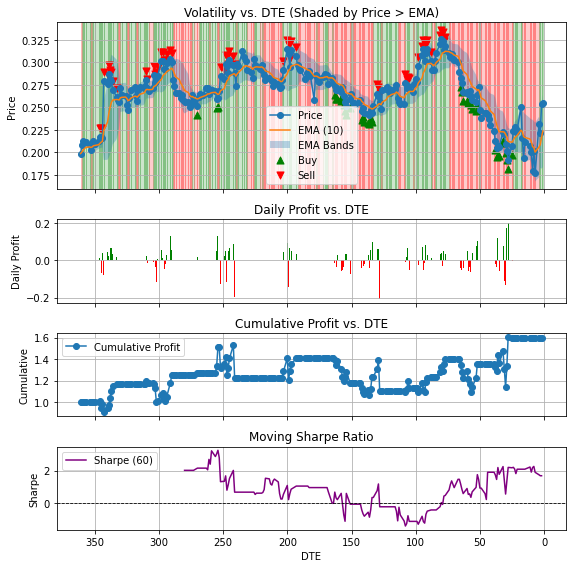

In [38]:
fig, axes = plot_price_profit_vs_dte(
    results_df,
    price_col='price',
    profit_col='profit_entry@t1_exit@t2',
    dte_col='DTE',
    ema_span=10,
    sharpe_span=60,
    signal_col='signal2',
    upper_band_col='upper_band',
    lower_band_col='lower_band'
)


Let try Backtest under a 1-day trading horizon: enter positions on the same day the signal appears (*t*), and exit the next day (*t+1*).


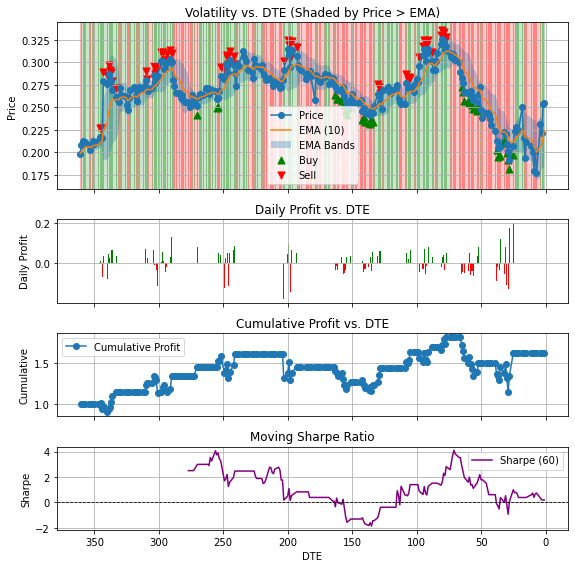

In [39]:
fig, axes = plot_price_profit_vs_dte(
    results_df,
    price_col='price',
    profit_col='profit_entry@t0_exit@t1',
    dte_col='DTE',
    ema_span=10,
    sharpe_span=60,
    signal_col='signal2',
    upper_band_col='upper_band',
    lower_band_col='lower_band'
)


#### Portfolio Metrics

In [40]:
def calculate_drawdown(prices):
    high_water_mark = prices.cummax()
    drawdowns = (prices - high_water_mark) / high_water_mark
    return drawdowns.min()

def sharpe_ratio(returns, risk_free_rate=0, trading_days=252):
    excess_return = returns - risk_free_rate
    return np.sqrt(trading_days) * (excess_return.mean() / excess_return.std())

def sortino_ratio(returns, risk_free_rate=0, trading_days=252):
    downside_returns = returns[returns < 0]
    expected_return = returns.mean() - risk_free_rate
    downside_deviation = np.std(downside_returns)
    return np.sqrt(trading_days) * (expected_return / downside_deviation)

def capm_regression(portfolio_returns, benchmark_returns, frequency='D'):
    # Resample returns to specified frequency
    resampled_portfolio = portfolio_returns.resample(frequency).mean()
    resampled_benchmark = benchmark_returns.resample(frequency).mean()
    aligned_portfolio, aligned_benchmark = resampled_portfolio.align(resampled_benchmark, join='inner')
    X = sm.add_constant(aligned_benchmark)
    model = sm.OLS(aligned_portfolio, X).fit()
    alpha = model.params[0]
    beta = model.params[1]
    return alpha, beta

def information_ratio(portfolio_returns, benchmark_returns, trading_days=252):
    active_return = portfolio_returns - benchmark_returns
    return active_return.mean() * np.sqrt(trading_days) / active_return.std()

def calculate_portfolio_performance(results_df, benchmark_returns = None, risk_free_rate_annual=0.04, trading_days=252):
    """
    Comprehensive portfolio performance metrics function.
    """
    # Convert annual risk-free rate to daily
    daily_risk_free = risk_free_rate_annual / trading_days
    
    # Portfolio returns
    portfolio_returns = results_df['profit_entry@t1_exit@t2']
    
    # Calculate cumulative return
    results_df['cumulative_return'] = (1 + portfolio_returns).cumprod() - 1
    
    # Mean & Std
    mean_daily_return = portfolio_returns.mean()
    std_daily_return = portfolio_returns.std()
    
    # Sharpe Ratio
    sharpe = sharpe_ratio(portfolio_returns.dropna(), risk_free_rate=daily_risk_free, trading_days=trading_days)
    
    # Sortino Ratio
    sortino = sortino_ratio(portfolio_returns.dropna(), risk_free_rate=daily_risk_free, trading_days=trading_days)
    
    # Max Drawdown
    cumulative_prices = (1 + portfolio_returns).cumprod()
    max_dd = calculate_drawdown(cumulative_prices)

    # Compute trade attempt rate
    trade_attempt = results_df[results_df['signal2'] != 0].shape[0] / results_df.shape[0]

    # Compute signal accuracy
    signal_accuracy = results_df[results_df['profit_entry@t1_exit@t2'] > 0].shape[0] / results_df[results_df['signal2'] != 0].shape[0]


    '''
    # CAPM Alpha & Beta
    portfolio_returns.index = pd.to_datetime(results_df['T'])
    benchmark_returns.index = portfolio_returns.index
    alpha, beta = capm_regression(portfolio_returns.dropna(), benchmark_returns.dropna(), frequency='W')
    
    # Information Ratio
    info_ratio = information_ratio(portfolio_returns.dropna(), benchmark_returns.dropna(), trading_days=trading_days)
    
    # T-test
    t_stat, p_value = ttest_ind(portfolio_returns.dropna(), benchmark_returns.dropna())
    paired_t_stat, paired_p_value = ttest_rel(portfolio_returns.dropna(), benchmark_returns.dropna())
    
    # Wilcoxon test
    wilcoxon_stat, wilcoxon_p = wilcoxon(portfolio_returns.dropna(), benchmark_returns.dropna())
    '''
    # Package results
    metrics = {
        "Start Date": results_df['t'].iloc[0],
        "End Date": results_df['T'].iloc[-1],
        "Mean Daily Return": mean_daily_return,
        "Std Dev of Return": std_daily_return,
        "Sharpe Ratio (Annualized)": sharpe,
        "Sortino Ratio (Annualized)": sortino,
        "Max Drawdown": max_dd,
        "trade attempt": trade_attempt,
        "Signal accuracy":signal_accuracy
        
        # "CAPM Alpha (Weekly)": alpha,
        # "CAPM Beta (Weekly)": beta,
        # "Information Ratio": info_ratio,
        # "Final Cumulative Return": results_df['cumulative_return'].iloc[-1] - 1,
        # "T-test Statistic vs " + benchmark_name: t_stat,
        # "T-test P-value vs " + benchmark_name: p_value,
        # "Paired T-test Statistic vs " + benchmark_name: paired_t_stat,
        # "Paired T-test P-value vs " + benchmark_name: paired_p_value,
        # "Wilcoxon Statistic vs " + benchmark_name: wilcoxon_stat,
        # "Wilcoxon P-value vs " + benchmark_name: wilcoxon_p
        
    }
    
    return pd.DataFrame([metrics])


In [41]:
calculate_portfolio_performance(results_df,risk_free_rate_annual=0.04, trading_days=252 )

,Start Date,End Date,Mean Daily Return,Std Dev of Return,Sharpe Ratio (Annualized),Sortino Ratio (Annualized),Max Drawdown,trade attempt,Signal accuracy
0,2022-01-03,2022-12-30,0.002836,0.044055,0.96453,0.888284,-0.302649,0.372549,0.568421


In [42]:
def compute_failures_summary(results_df, check_signal='None'):
    """
    Function to analyze failures in results_df['rep_port_exit']
    and return a summary DataFrame with total failures.
    
    If `check_signal` is provided, records where results_df[check_signal] == 0
    are skipped from failure checks.

    Parameters:
    results_df (pd.DataFrame): DataFrame containing 'rep_port_exit' column.
    check_signal (str): Column name to filter records where signal == 0 (default: 'None').

    Returns:
    pd.DataFrame: Summary with total failures, start date, and end date.
    """
    failures_summary = []  # Initialize list to store results

    # Loop through each index in results_df['rep_port_exit']
    for index in range(len(results_df['rep_port_exit'])):
        # Skip this record if check_signal is provided and the value is 0
        if check_signal != 'None' and results_df[check_signal].iloc[index] == 0:
            continue  # Skip to next iteration

        temp = results_df['rep_port_exit'][index]  # Extract the sub-DataFrame

        # Check if temp is None or empty and skip if necessary
        if temp is None or isinstance(temp, float) or (isinstance(temp, pd.DataFrame) and temp.empty):
            failures_summary.append({
                "index": index,
                "fail_P": 0,
                "fail_C": 0,
                "total_fail": 0
            })
            continue  # Skip to next iteration

        # Check conditions for 'P' and 'C'
        condition_P = temp[(temp['side'] == 'P') & ((temp['P_MID_new'].isna()) | (temp['P_MID_new'] <= 0))]
        condition_C = temp[(temp['side'] == 'C') & ((temp['C_MID_new'].isna()) | (temp['C_MID_new'] <= 0))]

        # Count violations
        num_fail_P = len(condition_P)
        num_fail_C = len(condition_C)
        total_fail = num_fail_P + num_fail_C

        # Store results
        failures_summary.append({
            "index": index,
            "fail_P": num_fail_P,
            "fail_C": num_fail_C,
            "total_fail": total_fail
        })

    # Convert to DataFrame
    failures_df = pd.DataFrame(failures_summary)

    # Compute total failures
    total_failures_sum = failures_df["total_fail"].sum()

    # Create final output DataFrame with Start Date, End Date, and Total Failures
    summary_df = pd.DataFrame([{
        "Start Date": results_df['t'].iloc[0],
        "End Date": results_df['T'].iloc[-1],
        "Check Exit Price": total_failures_sum
    }])

    return summary_df



In [43]:
compute_failures_summary(results_df, check_signal='signal2')

,Start Date,End Date,Check Exit Price
0,2022-01-03,2022-12-30,0


### Mean reversion test

Since our trading horizon is fixed (signal at *t*, entry at *t+1*, exit at *t+2*), the previous Bollinger Band strategy implicitly assumed the replicated volatility series is mean-reverting. To verify this, we test for mean reversion and experiment with series transformations to adjust the half-life (HL) so it better aligns with our trading horizon.

By tuning the HL, we aim to explore how different mean-reversion speeds affect signal timing and capture efficiency.


In [44]:
option_dict = {}

# Group by 'T' (expiry) and store plain DataFrames with 't' as index
# results_df['T_str'] = results_df['T'].dt.strftime('%Y%m%d')
for expiry, df_group in results_df.groupby('T'):
    df_group = df_group.copy()
    df_group.set_index('t', inplace=True)  # Set 't' as index
    option_dict[expiry] = df_group  # Use .date() for clean dictionary keys


In [45]:
def compute_half_life(series):
    """
    Compute half-life of mean reversion using an OLS estimate of an AR(1) process.
    """
    lagged = series.shift(1).dropna()
    delta = series.diff().dropna()
    delta = delta.loc[lagged.index]

    X = lagged.values.reshape(-1, 1)
    y = delta.values

    beta = np.linalg.lstsq(X, y, rcond=None)[0][0]

    if beta == 0:
        return np.inf

    return np.log(2) / abs(beta)

def zscore(series, window=5):
    """Compute rolling z-score of a series."""
    mean = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    return (series - mean) / std

def panel_adf_multi(option_dict, price_col='close', zscore_window=5):
    """
    Run ADF test and compute half-life for each expiry series in a dict of DataFrames.
    Apply multiple transformations: raw, diff, and z-score.
    
    Returns a DataFrame with:
      - expiry
      - method (raw, diff, zscore)
      - adf_stat, p_value, half_life
    """
    results = []

    for expiry, df in option_dict.items():
        series = df[price_col].dropna()

        if len(series) < 10:
            continue

        transformations = {
            '1_raw': series,
            '2_diff': series.diff().dropna(),
            '3_zscore': zscore(series, window=zscore_window).dropna()
        }

        for method, transformed in transformations.items():
            if len(transformed) < 10:
                continue

            try:
                adf_stat, p_value, *_ = adfuller(transformed)
                half_life = compute_half_life(transformed)

                results.append({
                    'expiry': expiry,
                    'method': method,
                    'adf_stat': adf_stat,
                    'p_value': f"{p_value:.5f}",
                    'p_value < 0.05': p_value < 0.05,
                    'half_life': half_life
                })
            except Exception as e:
                results.append({
                    'expiry': expiry,
                    'method': method,
                    'adf_stat': None,
                    'p_value': None,
                    'p_value < 0.05': None,
                    'half_life': None,
                    'error': str(e)
                })

    return pd.DataFrame(results)


In [46]:
panel_adf_multi(option_dict, price_col='price', zscore_window = 4).sort_values('method')

,expiry,method,adf_stat,p_value,p_value < 0.05,half_life
0,2022-12-30,1_raw,-2.891494,0.04635,True,6321.053690
1,2022-12-30,2_diff,-10.471905,0.00000,True,0.600665
2,2022-12-30,3_zscore,-6.459184,0.00000,True,1.123263


Although the replicated implied volatility is mean-reverting, its **half-life far exceeds our trade horizon**.
So we **transform the series to a faster-reverting version** (e.g., de-trend/EMA, z-score, or first-difference), then **rebuild signals and re-run the backtest** on this mean-reverted series (Z-score inthis case)


In [47]:
results_df_reverse = results_df.copy()
results_df_reverse['close_diff'] = results_df_reverse['price'].diff().dropna()
results_df_reverse['zscore'] =  zscore(results_df_reverse['price'], window=4).dropna()

# --- vol-of-vol (EMA of |Δprice|) ---
volatility_span = 10
volatility_benchmark = 0.01
results_df_reverse['vol_diff'] = results_df_reverse['price'].diff().abs()
results_df_reverse['vol_EMA']  = results_df_reverse['vol_diff'].ewm(span=volatility_span, adjust=False).mean()

# signal
bb_width = 1
z = results_df_reverse["zscore"].to_numpy()
v = results_df_reverse["vol_EMA"].to_numpy()
sig = np.zeros(len(z), dtype=int)
switch = 0  # 1=long, -1=short, 0=flat

for i, zi in enumerate(z):
    if np.isnan(zi):
        sig[i] = switch; continue
    if (switch == 1 and zi >= 0) or (switch == -1 and zi <= 0):
        switch = 0                               # reset when z crosses 0
    if switch == 0 and v[i] <= volatility_benchmark:   # enter only from flat AND vol-vol ok
        if zi <= -bb_width: switch = 1
        elif zi >=  bb_width: switch = -1
    sig[i] = switch

results_df_reverse["signal_zscore"] = sig
# if you execute at next close:
# results_df_reverse["signal_tplus1"] = results_df_reverse["signal_zscore"].shift(1).fillna(0).astype(int)


In [48]:
# backtest using entry at t, exit at t+1
results_df_reverse['pct_change'] = results_df_reverse['variance_exit'] / results_df_reverse['variance_entry'] * (1 - trading_fee) - 1
results_df_reverse['profit_zc'] = results_df_reverse['pct_change'].shift() * results_df_reverse['signal_zscore'] 

In [49]:
results_df_reverse

,t,T,DTE,vol_mid,variance_mid,data_length_mid,rep_port_mid,price,EMA,std,upper_band,lower_band,vol_diff,vol_EMA,ema_signal,signal,signal2,switch,t_entry,variance_entry,rep_port_entry,no_O_entry,rep_port_exit,t_exit,variance_exit,no_O_exit,pct_change,profit_entry@t1_exit@t2,profit_entry@t0_exit@t1,sharpe,cumulative_return,close_diff,zscore,signal_zscore,profit_zc
0,2022-01-03,2022-12-30,361.0,0.198744,0.039499,122,t T S K ...,0.198744,0.198744,NaN,NaN,NaN,NaN,NaN,0.198744,-1,0,0,2022-01-04,0.043205,t T S K ...,128,t T S K ...,2022-01-05,0.045545,128,0.048894,0.0,NaN,NaN,0.000000,NaN,NaN,0,NaN
1,2022-01-04,2022-12-30,360.0,0.207858,0.043205,128,t T S K ...,0.207858,0.200401,NaN,NaN,NaN,0.009115,0.009115,0.200401,-1,0,0,2022-01-05,0.045115,t T S K ...,128,t T S K ...,2022-01-06,0.044600,128,-0.016355,-0.0,0.0,NaN,0.000000,0.009115,NaN,0,0.0
2,2022-01-05,2022-12-30,359.0,0.212403,0.045115,128,t T S K ...,0.212403,0.202583,NaN,NaN,NaN,0.004545,0.008284,0.202583,-1,0,0,2022-01-06,0.044711,t T S K ...,128,t T S K ...,2022-01-07,0.044681,128,-0.005669,-0.0,-0.0,NaN,0.000000,0.004545,NaN,0,-0.0
3,2022-01-06,2022-12-30,358.0,0.211451,0.044711,128,t T S K ...,0.211451,0.204195,NaN,NaN,NaN,0.000952,0.006951,0.204195,-1,0,0,2022-01-07,0.044775,t T S K ...,128,t T S K ...,2022-01-10,0.043181,128,-0.040430,-0.0,-0.0,NaN,0.000000,-0.000952,0.615947,0,-0.0
4,2022-01-07,2022-12-30,357.0,0.211602,0.044775,128,t T S K ...,0.211602,0.205542,NaN,NaN,NaN,0.000151,0.005715,0.205542,-1,0,0,2022-01-10,0.043534,t T S K ...,128,t T S K ...,2022-01-11,0.041070,128,-0.061335,-0.0,-0.0,NaN,0.000000,0.000151,0.382231,0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2022-12-23,2022-12-30,7.0,0.176670,0.031212,259,t T S K ...,0.176670,0.200328,0.021684,0.232854,0.167802,0.025204,0.017541,0.200328,1,0,0,2022-12-26,0.053401,t T S K ...,259,t T S K ...,2022-12-27,0.037600,259,-0.299422,-0.0,-0.0,0.740389,0.601088,-0.025204,-0.981203,0,-0.0
251,2022-12-26,2022-12-30,4.0,0.231087,0.053401,259,t T S K ...,0.231087,0.205920,0.022366,0.239470,0.172371,0.054417,0.024246,0.205920,-1,0,0,2022-12-27,0.048869,t T S K ...,259,t T S K ...,2022-12-28,0.058283,259,0.186689,0.0,-0.0,0.353649,0.601088,0.054417,1.342463,0,-0.0
252,2022-12-27,2022-12-30,3.0,0.221063,0.048869,259,t T S K ...,0.221063,0.208674,0.017260,0.234563,0.182784,0.010024,0.021660,0.208674,-1,0,0,2022-12-28,0.064306,t T S K ...,259,t T S K ...,2022-12-29,0.087854,259,0.359352,0.0,0.0,0.200803,0.601088,-0.010024,0.558810,0,0.0
253,2022-12-28,2022-12-30,2.0,0.253587,0.064306,259,t T S K ...,0.253587,0.216840,0.023248,0.251711,0.181968,0.032524,0.023635,0.216840,-1,0,0,2022-12-29,0.064678,t T S K ...,259,t T S K ...,2022-12-30,0.021618,259,-0.667430,-0.0,0.0,0.200803,0.601088,0.032524,1.021492,0,0.0


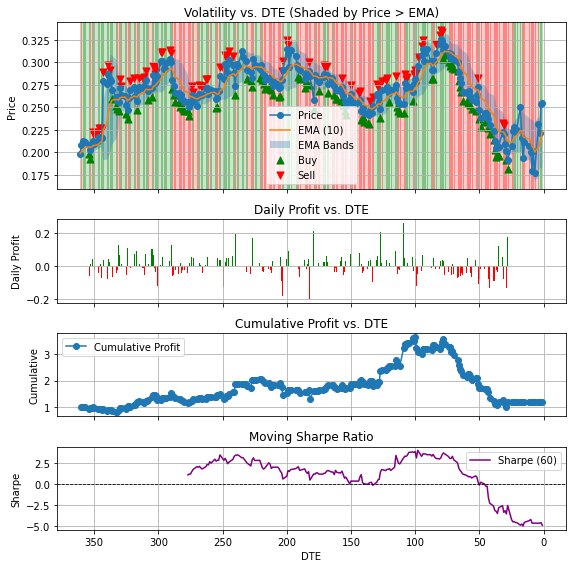

In [50]:
# assuming plot_price_profit_vs_dte() is already defined/imported

fig, axes = plot_price_profit_vs_dte(
    df=results_df_reverse,
    price_col='price',
    profit_col='profit_zc',
    dte_col='DTE',
    ema_span=10,
    sharpe_span=60,
    signal_col='signal_zscore',   
    upper_band_col='upper_band',   
    lower_band_col='lower_band',
    title_prefix='Volatility vs. DTE'
)


#### Summary and Improvement

The portfolio works well until the replicating implied volatility having downward trend.
The market condition may changed and the half-life may chnage over time and thus signal, trading style and our trade horizon do not fit each other.


Below show that the HL decrease to less than 1 day when option is about 1 month to expiry date. Thus our original strategy cannot capture this anomaly in time, or mean-reversion doesnt work.

What can be improved here
- To dynamically track volatility trends to halt trading when implied volatility shows a clear breakout, and adjust the series’ half-life to match the trading horizon 
- As option approach maturity, the volatility of implied volatility itself may increase; therefore, we can impose a constraint to halt trading once it exceeds a specified threshold. Or avoid trading when maturity approach
- In this project, we enter the position with 100% of our portfolio. With proper sizing management, we should be able to mitigate losses.
- One constraint is that our trading horizon is limited to a 1-day holding period, though in practice we may extend beyond this

In [51]:
option_dict_tmp = option_dict.copy()
option_dict_tmp['2022-12-30'] = option_dict['2022-12-30'].query("DTE < 30")

panel_adf_multi(option_dict_tmp, price_col='price', zscore_window = 4).sort_values('method')

,expiry,method,adf_stat,p_value,p_value < 0.05,half_life
0,2022-12-30,1_raw,-2.082606,0.25157,False,80.835430
1,2022-12-30,2_diff,-6.238079,0.00000,True,0.501863
2,2022-12-30,3_zscore,-2.089942,0.24858,False,0.790190


## Loop for multiple expiry date

In [52]:
options_data['T'].value_counts().head()

2021-12-17    111150
2022-12-16     95120
2022-09-16     84780
2022-06-17     80103
2022-03-18     78496
Name: T, dtype: int64

In [53]:
expiry_set = ['2021-12-31', '2022-03-31', '2022-06-30', '2022-09-30','2022-12-30']
# expiry_set = ['2021-12-31', '2022-06-30', '2022-12-30']

In [54]:
if False:
    # Initialize an empty DataFrame to store results
    columns = [
        "Start Date", "End Date", "Mean Daily Return", "Std Dev of Return",
        "Sharpe Ratio (Annualized)", "Sortino Ratio (Annualized)", 
        "Max Drawdown", "trade attempt", "Signal accuracy", "Check Exit Price"
    ]
    performance_results = pd.DataFrame(columns=columns)
    performance = []
    results_df_collect = pd.DataFrame() 

    # Loop through each expiry in expiry_set
    for expiry in expiry_set:
        
        # Filter unique_pairs for the current expiry
        unique_pairs_used = unique_pairs[unique_pairs['T'] == expiry]

        results_tmp = []
        # Iterate through each unique (t, T) pair
        for index, row in unique_pairs_used.iterrows():
            quote_date = row['t']
            expiry_date = row['T']
            dte = row['DTE']  # Days to expiry
            
            # Run IV_rep_port function
            try:
                # vol_last_adj, variance_last_adj, K_length_last_adj , rep_port_last_adj = IV_rep_port(
                #     options_data, quote_date, expiry_date, price_used='last_adj'
                # )
                vol_mid, variance_mid, K_length_mid , rep_port_mid = IV_rep_port(
                    options_data, quote_date, expiry_date, price_used='mid'
                )


                # Store iteration results
                results_tmp.append({
                    't': quote_date,
                    'T': expiry_date,
                    'DTE': dte,
                    # 'vol_last_adj': vol_last_adj,
                    # 'variance_last_adj': variance_last_adj,
                    # 'data_length': data_length,
                    # 'rep_port_last_adj': rep_port_last_adj,
                    'vol_mid': vol_mid,
                    'variance_mid': variance_mid,
                    'K_length_mid': K_length_mid,
                    'rep_port_mid': rep_port_mid
                })

            except Exception as e:
                print(f"Error processing {quote_date} - {expiry_date}: {e}")

        # Convert results to a DataFrame
        results_df_tmp = pd.DataFrame(results_tmp).reset_index(drop=True)

        # Sort results
        results_df_tmp = results_df_tmp.sort_values(by='DTE', ascending=False)

        # Compute trading signals
        results_df_tmp = compute_trading_signals(
            results_df_tmp, ema_span=34, vol_span=20, vol_vol_span =10, bb_switch=2, vol_vol_benchmark=0.015
        )

        # Shift variance and replicating portfolio entry
        trading_fee = 0.005
        results_df_tmp['t_entry']  = results_df_tmp['t'].shift(-1)
        results_df_tmp['variance_entry'] = results_df_tmp['variance_mid'].shift(-1) 
        results_df_tmp['rep_port_entry'] = results_df_tmp['rep_port_mid'].shift(-1) 
        results_df_tmp['no_O_entry'] = results_df_tmp['rep_port_entry'].apply(
            lambda df: len(df) if isinstance(df, pd.DataFrame) else 0
        )

        # Apply exit calculations
        days_to_shift = 1  
        max_valid_index = len(results_df_tmp) - days_to_shift 
        results_df_tmp.reset_index(drop=True, inplace=True)
        results_df_tmp['rep_port_exit'] = None

        for idx in range(max_valid_index):  
            row = results_df_tmp.loc[idx]  
            rep_port_exit = update_rep_port_exit(row, options_data, days_to_shift)
            results_df_tmp.at[idx, 'rep_port_exit'] = rep_port_exit

        results_df_tmp['t_exit'] = results_df_tmp['rep_port_exit'].apply(
            lambda df: df['t'].iloc[0] if isinstance(df, pd.DataFrame) and not df.empty else None
        )
    
        results_df_tmp['variance_exit'] = results_df_tmp['rep_port_exit'].apply(
            lambda df: df['w_O'].sum() if isinstance(df, pd.DataFrame) and not df.empty else None
        )

        results_df_tmp['no_O_exit'] = results_df_tmp['rep_port_exit'].apply(
            lambda df: len(df) if isinstance(df, pd.DataFrame) else 0
        )

        results_df_tmp['pct_change'] = results_df_tmp['variance_exit'] / results_df_tmp['variance_entry'] * (1 - trading_fee) - 1
        results_df_tmp['profit'] = results_df_tmp['pct_change'] * results_df_tmp['signal2'] 
        results_df_collect = pd.concat([results_df_collect, results_df_tmp], ignore_index=True)

        # Compute performance metrics
        performance = calculate_portfolio_performance(results_df_tmp, risk_free_rate_annual=0.04, trading_days=252)

        # Compute failure summary
        failure_summary = compute_failures_summary(results_df_tmp, check_signal='signal2')

        # Extract the "Check Exit Price" column from the failure summary
        check_exit_price = failure_summary["Check Exit Price"].iloc[0] if not failure_summary.empty else 0

        # Append "Check Exit Price" to the result DataFrame
        performance["Check Exit Price"] = check_exit_price

        # Append the iteration result
        performance_results = pd.concat([performance_results, performance], ignore_index=True)




In [55]:
# results_df_collect.to_csv('results_df.csv', index=False)